In [240]:
'''
This Notebook demonstrates a sample application of four ensemble smoother data assimilation (DA) schemes for assimilating MODIS fractional snow cover area (fSCA) into a hydrological model. Here the main goal is to get an improved estimate of snow water equivalent (SWE) during the maximum accumulation period. 

The DA schemes used are:
1. Particle batch smoother (Pbs)
2. LoA (adopted from GLUE LoA)
3. Pbs_F (fuzzy logic based variant of Pbs)
4. LoA_F (fuzzy logic based variant of LoA)

The last three DA schemes were newly introduced in the following paper and for details about the conceptual background and for further information about the implementation strategy of these DA schemes the reader is referred to this paper.

Teweldebrhan, A., Burkhart, J., Schuler, T., and Xu, C.-Y.: Improving the Informational Value of MODIS Fractional Snow Cover Area Using Fuzzy Logic Based Ensemble Smoother Data Assimilation Frameworks, Remote Sensing, 11, 28, 2019.

https://www.mdpi.com/2072-4292/11/1/28
'''

In [1]:
import numpy as np

from scipy import stats
from scipy import io
import collections

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter


In [2]:
# returns Ne x No weight values using a triangular membership function
def get_wt_trimf(R, value):
    a = -np.sqrt(R)
    b = np.sqrt(R)
    x_ens = value
    m = 0
    wt_ens = []
    perc_satis_obsns = []
    for x_ens_i in x_ens:
        wt_ens_i = []
        binary_satis_obsns = []
        binary_val = 0
        for x_ens_t_i in x_ens_i:
            if x_ens_t_i <= a:
                wt_i = 0
            elif a < x_ens_t_i and x_ens_t_i < m:
                wt_i = ((x_ens_t_i - a) / (m - a))
            elif x_ens_t_i == m:
                wt_i = 1.0
            elif m < x_ens_t_i and x_ens_t_i < b:
                wt_i = ((b - x_ens_t_i) / (b - m))
            elif x_ens_t_i >= b:
                wt_i = 0
            wt_ens_i.append(wt_i)
            if wt_i > 0: binary_val += 1

        wt_ens.append(wt_ens_i)
        perc_satis_obsns.append(np.sum(binary_val) / len(x_ens_i))

    return wt_ens, perc_satis_obsns


In [3]:
# Computes weight of each observation with respect to its location in the time axis
def get_type_2_mf(a_A, b_A, day_idx,alpha_A, beta_A):
    x=day_idx
    alpha_A= (a_A-x[0])*0.15
    beta_A= (x[-1]-b_A)*0.15
    t2_wt=[]
    for x_i in x:
        if x_i <= a_A:
            t2_wt_i = np.exp(-((a_A-x_i)/alpha_A))
        elif x_i >= a_A and x_i <= b_A:
            t2_wt_i = 1
        elif x_i >= b_A:
            t2_wt_i = np.exp(-((x_i-b_A)/beta_A))
        t2_wt.append(t2_wt_i)

    return t2_wt

In [4]:
# Calculate persistency score of an ensemble member using L-function
def get_perc_days_mf(fracn_obsns_satisfied):

    x = fracn_obsns_satisfied
    a = 0.5
    b = 0.95
    perc_wt = []

    for x_i in x:
        if x_i < a:
            wt_i = 0.0
        elif a <= x_i and x_i <= b:
            wt_i = ((x_i - a) / (b - a))
        elif x_i > b:
            wt_i = 1.0
        perc_wt.append(wt_i)

    return perc_wt


In [5]:
# Compute weighted quantile values
def get_weighted_quantile(values, quantiles, sample_weight=None):
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)

    return np.interp(quantiles, weighted_quantiles, values)


In [6]:
# Perofrms the DA analysis and it returns reanalysed quantile 
# values as its main output 

def DA_analysis(o_scf, d_idx, s_scf, s_swe, c_idx, R_val, q, Ne, t2f):
    s_swe_q_p = []
    s_scf_q_p = []

    s_swe_q_pbs = []
    s_scf_q_pbs = []
    s_swe_q_loa = []
    s_scf_q_loa = []
    o_scf_ac = []
    v = 0

    for i in c_idx:
        o_scf_i = np.array(o_scf)[i, :]
        o_scf_idx = np.where(o_scf_i != -9999)[0]
        o_scf_idx = np.array(o_scf_idx)[o_scf_idx <= o_scf_idx[len(o_scf_idx)-1]]
        o_scf_i_valid = o_scf_i[o_scf_idx]

        if t2f:
            a_A = o_scf_idx[cpts[v, 0]];
            b_A = o_scf_idx[cpts[v, 1]];
            dd_idx = o_scf_idx
            v += 1

        No = len(o_scf_i_valid)

        s_scf_ens_valid = np.array(s_scf)[:, i, o_scf_idx]
        obs_date_idx = d_idx[i]
        s_swe_at_date_idx = np.array(s_swe)[:, i, obs_date_idx]

        t2_wt = 1.0
        if t2f: t2_wt = get_type_2_mf(a_A, b_A, dd_idx, alpha_A=None, beta_A=None)

        R_inv = (1 / R_val) * np.ones((1, No))
        Res_org = np.tile(o_scf_i_valid, (np.size(s_scf_ens_valid, 0), 1))\
                  -s_scf_ens_valid

        Res = [Res_org[i, :] * t2_wt for i in range(Ne)]
        Res_sq = R_inv.dot((np.array(Res) ** 2).T)
        LH = np.exp(-0.5 * Res_sq)
        w = LH / np.sum(LH)
        wt = np.array(w)[0]
        s_swe_q_i = get_weighted_quantile(s_swe_at_date_idx, q, wt)
        s_swe_q_pbs.append(s_swe_q_i)
        wt_2_org, fracn_obsns_satisfied = get_wt_trimf(R_val, Res_org)
        wt_2_t = [np.array(wt_2_org)[i, :] * t2_wt for i in range(Ne)]
        wt_2 = np.sum(wt_2_t, 1)
        wt_ens_s = wt_2 / np.sum(wt_2)

        if t2f:
            wt_perc_satis_obs = get_perc_days_mf(fracn_obsns_satisfied)
            wt_ens_s_2 = wt_ens_s * wt_perc_satis_obs
            wt_ens_s = wt_ens_s_2 / np.sum(wt_ens_s_2)

        s_swe_q_i_2 = get_weighted_quantile(s_swe_at_date_idx, q, wt_ens_s)
        s_swe_q_loa.append(s_swe_q_i_2)
        s_swe_q_i_prior = get_weighted_quantile(s_swe_at_date_idx, q)
        s_swe_q_p.append(s_swe_q_i_prior)

        # initialize objects for storing scf related data
        o_scf_cell = [];
        s_scf_q_pbs_cell = [];
        s_scf_q_loa_cell = [];
        s_scf_q_p_cell = []

        for t in range(len(o_scf_i_valid)):
            s_scf_q_i = get_weighted_quantile(np.array(s_scf_ens_valid)[:, t], q, wt)
            s_scf_q_pbs_cell.append(s_scf_q_i)
            s_scf_q_i_2 = get_weighted_quantile(np.array(s_scf_ens_valid)[:, t], q, wt_ens_s)
            s_scf_q_loa_cell.append(s_scf_q_i_2)
            s_scf_q_i_prior = get_weighted_quantile(np.array(s_scf_ens_valid)[:, t], q)
            s_scf_q_p_cell.append(s_scf_q_i_prior)
            o_scf_cell.append(o_scf_i_valid[t])

        o_scf_ac.append(o_scf_cell)
        s_scf_q_pbs.append(s_scf_q_pbs_cell)
        s_scf_q_loa.append(s_scf_q_loa_cell)
        s_scf_q_p.append(s_scf_q_p_cell)

    return s_swe_q_p, s_swe_q_pbs, s_swe_q_loa, \
           s_scf_q_p, s_scf_q_pbs, s_scf_q_loa, \
           o_scf_ac

In [7]:
def get_stat(obs, sim, bm):
    obs=np.array(obs)
    sim=np.array(sim)
    bm=np.array(bm)

    # compute mean bias
    mean_bias_bm = np.mean(np.abs(obs - bm))
    mean_bias_ass = np.mean(np.abs(obs - sim))
    # compute RMSE
    rmse_bm= np.sqrt(np.mean((obs - bm) ** 2))
    rmse_ass = np.sqrt(np.mean((obs - sim) ** 2))
    #compute R
    r_p_bm=stats.pearsonr(obs, bm)
    r_p_ass=stats.pearsonr(obs, sim)

    return mean_bias_bm,mean_bias_ass,rmse_bm,rmse_ass,r_p_bm,r_p_ass

In [8]:
def eval_DA_scheme(o_swe, s_swe_bm, s_swe_q_pbs, s_swe_q_loa,
                   o_scf_ac,s_scf_ac, s_scf_q_pbs,s_scf_q_loa):

    stat_result = []
    stat_result.append(["Variable", "DA", "BIAS", "RMSE", "R", "p"])

    # evaluate Pbs based assimilation effect on swe.
    # N.B. the unit of swe is converted from mm to m here
    mean_bias_bm, mean_bias_ass, rmse_bm, rmse_ass, r_p_bm, r_p_ass = \
        get_stat(np.array(o_swe) / 1000,
                 np.array(s_swe_q_pbs) / 1000,
                 np.array(s_swe_bm) / 1000)
    stat_result.append(["SWE", "Ben", np.str(np.round(mean_bias_bm, 3)),
                        np.str(np.round(rmse_bm, 3)),
                        np.str(np.round(r_p_bm[0], 3)), r_p_bm[1]])
    stat_result.append(["SWE", "Pbs", np.str(np.round(mean_bias_ass, 3)),
                        np.str(np.round(rmse_ass, 3)),
                        np.str(np.round(r_p_ass[0], 3)),
                        r_p_ass[1]])

    # evaluate LoA based assimilation effect on swe
    mean_bias_bm, mean_bias_ass, rmse_bm, rmse_ass, r_p_bm, r_p_ass = \
        get_stat(np.array(o_swe) / 1000,
                 np.array(s_swe_q_loa) / 1000,
                 np.array(s_swe_bm) / 1000)
    stat_result.append(["SWE", "LoA", np.str(np.round(mean_bias_ass, 3)),
                        np.str(np.round(rmse_ass, 3)),
                        np.str(np.round(r_p_ass[0], 3)),
                        r_p_ass[1]])

    # evaluate SCF
    # convert the 2d bm data to 1d to confer with the other datasets.
    # here it is used to remove the extra dimension
    o_scf_ac = flatten(o_scf_ac)
    s_scf_q_pbs = flatten(s_scf_q_pbs)
    s_scf_ac = flatten(s_scf_ac)
    s_scf_q_loa = flatten(s_scf_q_loa)

    # evaluate Pbs based assimilation effect on scf
    mean_bias_bm, mean_bias_ass, rmse_bm, rmse_ass, r_p_bm, r_p_ass = \
        get_stat(o_scf_ac, s_scf_q_pbs, s_scf_ac)
    stat_result.append(["SCF", "Ben", np.str(np.round(mean_bias_bm, 3)),
                        np.str(np.round(rmse_bm, 3)),
                        np.str(np.round(r_p_bm[0], 3)),
                        r_p_bm[1]])
    stat_result.append(["SCF", "Pbs", np.str(np.round(mean_bias_ass, 3)),
                        np.str(np.round(rmse_ass, 3)),
                        np.str(np.round(r_p_ass[0], 3)),
                        r_p_ass[1]])

    # evaluate LoA based assimilation effect on scf
    mean_bias_bm, mean_bias_ass, rmse_bm, rmse_ass, r_p_bm, r_p_ass = \
        get_stat(o_scf_ac,s_scf_q_loa,s_scf_ac)
    stat_result.append(["SCF", "LoA", np.str(np.round(mean_bias_ass, 3)),
                        np.str(np.round(rmse_ass, 3)),
                        np.str(np.round(r_p_ass[0], 3)),
                        r_p_ass[1]])

    return stat_result


In [9]:

def bar_plot_2(BIAS_STAT,RMSE_STAT,R_STAT,output_fname):
    my_dpi = 86  # for my monitor, dpi 302=>4cm
    fig, (ax1, ax2,ax3)  = \
        plt.subplots(figsize=(800 / my_dpi, 300 / my_dpi), dpi=my_dpi,nrows=1, ncols=3)
    width = 0.15
    for i in range(3): # for each of the three bar subplots, viz for bias, rmse and r
        stat_i=[BIAS_STAT, RMSE_STAT, R_STAT][i]
        BM=stat_i[0].astype(float)
        pbs=stat_i[1].astype(float)
        pbs_F=stat_i[2].astype(float)
        LoA=stat_i[3].astype(float)
        LoA_F=stat_i[4].astype(float)
        x_label=stat_i[5]
        sim_years=stat_i[6]
        ind = np.arange(len(sim_years))
        ax=[ax1,ax2,ax3][i]
        ax.barh(ind, BM, width, color='salmon', edgecolor ='none', label='prior')
        ax.barh(ind + width, pbs, width, color='forestgreen', edgecolor ='none',label='Pbs')
        ax.barh(ind + width*2, pbs_F,width,  color='lawngreen', edgecolor ='none',label='Pbs_F')
        ax.barh(ind + width*3, LoA, width, color='dodgerblue', edgecolor ='none', label='LoA')
        ax.barh(ind + width*4, LoA_F, width,  color='skyblue', edgecolor ='none', label='LoA_F')
        ax.set_xlabel(x_label, fontsize=11)
        ax.set_yticks(ind + width)
        ax.set_yticklabels([])
        xlim = ax.get_xlim()
        ax.xaxis.set_ticks([xlim[1]*0.05, xlim[1]*0.25, xlim[1]*0.5, xlim[1]*0.75, xlim[1]*0.95])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # ax.set_ylabel([])
        if ax==ax1:
            ax.set_yticklabels(sim_years)
            ax.set_ylabel('year', fontsize=11)

    font = {'size': 11}
    plt.rc('font', **font)
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2, wspace=0.05)
    ax3.legend(loc='upper center', bbox_to_anchor=(-0.4, -0.2),
              fancybox=False, shadow=False, ncol=5, fontsize = 11)
    fig.savefig(output_fname, format="pdf")
    plt.show()


In [23]:
# Display the evaluation results for the DA schemes in tabular form 
def eval_metrics_table(stat_result,sim_years):
    print('Evaluation result')

    dash = '-' * 64

    for y in range(len(sim_years)):
        if sim_years[y]==2010:
            y_i=0
        elif sim_years[y]==2011:
            y_i=1
        elif sim_years[y]==2012:
            y_i=2
            
        for p in range(2): 
            data = np.array(stat_result)[y_i,p,:,:]
            data_shape = data.shape
            year = sim_years[y]

            print('-------------------------------------------------')
            if p == 0: print('Eval. metrics for Pbs and LoA schemes in year:', np.str(year))
            if p == 1: print('Eval.etrics for Pbs_F and LoA_F in year:', np.str(year))

            for i in range(data_shape[0]): 
                if i == 0:
                    print(dash)
                    print('{:<10s}{:>4s}{:>12s}{:>12s}{:>12s} {:>12s}'
                          .format(data[i,0], data[i,1],data[i,2],
                            data[i,3],data[i, 4], data[i,5]))
                    print(dash)
                else:
                    print(
                        '{:<10s}{:>4s}{:>12s}{:>12s}{:>12s} {:>12s}'
                            .format(data[i,0], data[i,1],
                            np.str(np.nanmean(np.round(np.float64(data[i, 2]),3))),
                            np.str(np.nanmean(np.round(np.float64(data[i, 3]),3))),
                            np.str(np.nanmean(np.round(np.float64(data[i, 4]),3))),
                            np.str(np.nanmean(np.round(np.float64(data[i, 5]),5)))))

In [12]:
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [13]:
# Setup the data assmilation strategy

Ne = 100
itern_len=1 #100
R_val=0.0225 # The variance of MODIS fSCA observations

# set the reanalysis period
sim_years=np.arange(2010,2013,1)

#set the quantile value for which the reanalysed SWE and SCF values are needed
quantile= 0.5 #[0.05,0.5,0.95] 

cells_to_excl = [5,32] # outliers to be excluded from reanalysis
# index of cells to be reanalyzed after excluding the outliers
cells_idx_an =np.delete(range(35),cells_to_excl) 

'''
One of the main advantages of smoothing over filtering techniques 
is that the analysis step can be done independent of the forward model. 
This sample application of the DA schemes will proceed assuming that 
the prior simulations were retrieved following the steps below. 
    
for y in range(len(sim_years)):
    # Get Ne set of perturbed model parameters using relevant distribution 
      functions   

    for n in range(Ne):
        # 1. Run model using perturbed values of each particle 
             (ensemble member)
        # 2. Retrieve simulated values (SWE and SCF) for each grid-cell 
             and all time-steps in the assimilation cycle
        # 3. Get observed assimilation variables, i.e. SWE 
             (for use in evaluation) and MODIS SCF (assimilated variable)

The results obtained following these steps were stored in a mat file from 
which we are going to import the required prior simulations, the observational 
data set (swe) as well as the assimilated observations (MODIS SCA).

NB. here only a single iteration was used to generate the prior values. 
But for practical applications, we may need several iterations (typically 100).

'''
# load input data to the DA algorithm
DA_inp_mat = io.loadmat('obsSCF_obsSWEday_obsSWE_simSCF_simSWE_2.mat')
DA_inp_data = DA_inp_mat['data']
cpts_inp_mat = io.loadmat('timing_window_critical_pts.mat')
cpts_data_all_yrs = cpts_inp_mat['data']

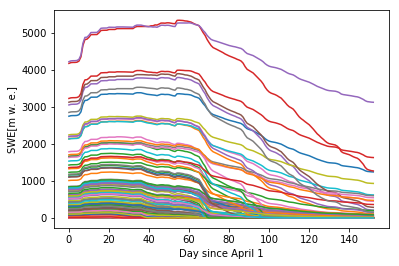

In [14]:
# explore the simulated ensemble SWE values for the ablation period

grd=0 # grid cell index [0-33]
year_i = 1 # analysis year index[0-2]

#---------------------------

sim_SWE = DA_inp_data[0][4][year_i] 

plt.plot(sim_SWE[:,grd,:].T)
plt.xlabel('Day since April 1')
plt.ylabel('SWE[m w. e.]')
plt.show()



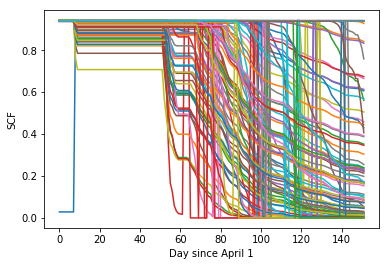

In [15]:
# explore the simulated ensemble SCF values for the ablation period

grd=0 # grid cell index [0-33]
year_i = 2 # analysis year index[0-2]
#---------------------------
 
sim_scf = DA_inp_data[0][3][year_i]

plt.plot(sim_scf[:,grd,:].T)
plt.xlabel('Day since April 1')
plt.ylabel('SCF')
plt.show()


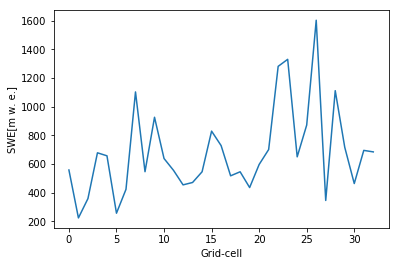

In [16]:
# explore spatial variablity of observed SWE values between the grid-cell for selected analysis year

year_i = 2 # analysis year index[0-2]
#---------------------------

obs_SWE = DA_inp_data[0][2][year_i][0]

plt.plot(obs_SWE.T)
plt.xlabel('Grid-cell')
plt.ylabel('SWE[m w. e.]')
plt.show()

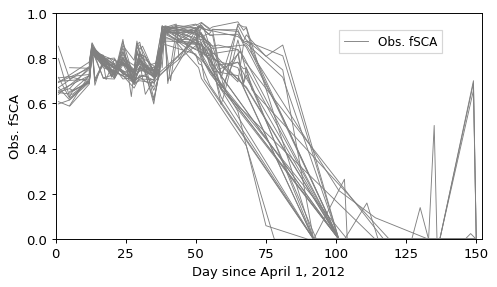

In [24]:
# explore evolution of the observed SCF values with time for selected analysis year

year_i = 2 # analysis year index[0-2]

#---------------------------
obs_scf=DA_inp_data[0][0][year_i]
year = sim_years[year_i]

my_dpi = 86  # for my monitor, and dpi 302=>4cm
fig, ax = plt.subplots(figsize=(550 / my_dpi, 300 / my_dpi),dpi=my_dpi,nrows=1,ncols=1)

# plot the SCF evolution with time excluding days without observation
for i in cells_idx_an:
    obs_scf_i = np.array(obs_scf)[i, :]
    obs_scf_idx = np.where(obs_scf_i != -9999)[0]
    obs_scf_idx = np.array(obs_scf_idx)[obs_scf_idx<=obs_scf_idx[len(obs_scf_idx)-1]]
    obs_scf_i_valid = obs_scf_i[obs_scf_idx]

    scf_valid_t=obs_scf_idx
    ax.plot(scf_valid_t,obs_scf_i_valid,lw=0.75,ls='-',marker='',color='grey',label='Obs. fSCA')
    ax.xaxis.set_ticks([0,25, 50,75, 100,125, 150])

    ax.set_xlabel("Day since April 1, "+ np.str(year), fontsize=11)
    ax.set_ylim([0, 1.0])
    ax.set_xlim([0, 152])
    ax.set_ylabel("Obs. fSCA", fontsize=11)

    for item_1 in ([ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
        item_1.set_fontsize(11)
    if i == 0:
        h1, l1 = ax.get_legend_handles_labels()
        ax.legend(h1, l1,loc='upper right', prop={'size': 10},
                  bbox_to_anchor=(0.92, 0.95), fancybox=False, shadow=False, ncol=5)
plt.show()

In [18]:
# run the DA schemes for each analysis year, evaluate the results 
# from the DA schemes, and store the resulting statistics
stat_result = []

for y in range(len(sim_years)):
    year = sim_years[y]
    obs_scf=DA_inp_data[0][0][y]
    obs_SWE_day = DA_inp_data[0][1][y][0]
    obs_SWE = DA_inp_data[0][2][y][0]
    sim_scf = DA_inp_data[0][3][y]
    sim_SWE = DA_inp_data[0][4][y]

    cpts =cpts_data_all_yrs[y]

    # Perform DA analysis using the original formulations of Pbs and LoA
    type2_FOS = False
    prior_swe_yr, pbs_swe_yr, LoA_swe_yr, prior_scf_yr, pbs_scf_yr, LoA_scf_yr, obs_scf_yr = \
        DA_analysis(obs_scf, obs_SWE_day, sim_scf,sim_SWE,cells_idx_an, R_val, quantile, Ne,type2_FOS)

    # Perform DA analysis using the fuzzy-logic based variants of Pbs and LoA (i.e. Pbs_F and LoA_F)
    type2_FOS = True
    prior_swe_yr, pbsF_swe_yr, LoAF_swe_yr, prior_scf_yr, pbsF_scf_yr, LoAF_scf_yr, obs_scf_yr = \
        DA_analysis(obs_scf, obs_SWE_day, sim_scf, sim_SWE,cells_idx_an, R_val, quantile,Ne,type2_FOS)

    # Evaluate DA performances using some standard eval metrics
    stat_result_f = eval_DA_scheme(obs_SWE, prior_swe_yr,
                                   pbs_swe_yr, LoA_swe_yr,
                                   obs_scf_yr, prior_scf_yr,
                                   pbs_scf_yr, LoA_scf_yr)

    stat_result_t = eval_DA_scheme(obs_SWE, prior_swe_yr,
                                   pbsF_swe_yr, LoAF_swe_yr,
                                   obs_scf_yr, prior_scf_yr,
                                   pbsF_scf_yr, LoAF_scf_yr)

    # store evaluation metrics for all years and current iteration
    stat_result.append([stat_result_f, stat_result_t])


In [19]:
np.array(stat_result).shape


(3, 2, 7, 6)

In [20]:
# display the evaluation metrics table for one or more of the three analysis years
sim_year = [2010,2011]        #[2010,2011,2012] 
eval_metrics_table(stat_result,sim_year)


Evaluation result
-------------------------------------------------
Eval. metrics for Pbs and LoA schemes in year: 2010
----------------------------------------------------------------
Variable    DA        BIAS        RMSE           R            p
----------------------------------------------------------------
SWE        Ben       0.143       0.168       0.121      0.50354
SWE        Pbs       0.124       0.154       0.596      0.00025
SWE        LoA       0.122        0.15       0.215      0.22926
SCF        Ben       0.077       0.126       0.982          0.0
SCF        Pbs       0.065       0.112       0.986          0.0
SCF        LoA       0.075       0.124       0.981          0.0
-------------------------------------------------
Eval.etrics for Pbs_F and LoA_F in year: 2010
----------------------------------------------------------------
Variable    DA        BIAS        RMSE           R            p
----------------------------------------------------------------
SWE        B

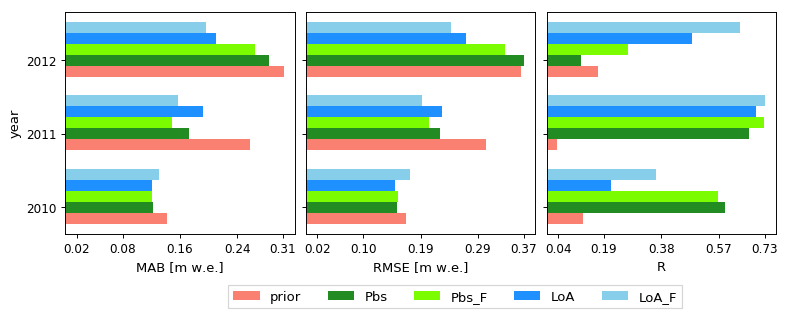

In [21]:
# Display SWE evaluation metrics in horizontal barcharts for the three analysis years 
sr = np.array(stat_result)
            #   BM          Pbs         Pbs_F       LoA         LoA_F
bar_plot_2([sr[:,0,1,2],sr[:,0,2,2],sr[:,1,2,2],sr[:,0,3,2],sr[:,1,3,2],'MAB [m w.e.]',sim_years],
           [sr[:,0,1,3],sr[:,0,2,3],sr[:,1,2,3],sr[:,0,3,3],sr[:,1,3,3],'RMSE [m w.e.]',sim_years],
           [sr[:,0,1,4],sr[:,0,2,4],sr[:,1,2,4],sr[:,0,3,4],sr[:,1,3,4],'R', sim_years],
           'mean_SWE_stat_subplots.pdf')

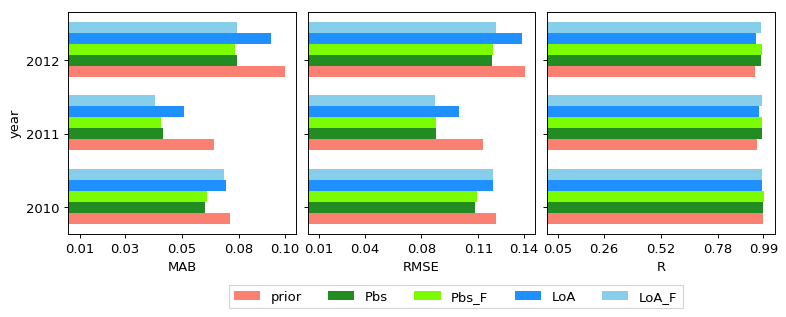

In [22]:
# Display SCF evaluation metrics in horizontal barcharts for the three analysis years 
sr = np.array(stat_result)
            #   BM          Pbs         Pbs_F       LoA         LoA_F
bar_plot_2([sr[:,0,4,2],sr[:,0,5,2],sr[:,1,5,2],sr[:,0,6,2],sr[:,1,6,2], 'MAB', sim_years],
           [sr[:,0,4,3],sr[:,0,5,3],sr[:,1,5,3],sr[:,0,6,3],sr[:,1,6,3], 'RMSE', sim_years],
           [sr[:,0,4,4],sr[:,0,5,4],sr[:,1,5,4],sr[:,0,6,4],sr[:,1,6,4], 'R', sim_years],
           'mean_SCF_stat_subplots.pdf')

In [263]:
# further explorations on the DA assimilation effect

# 1. change the quantile value to 0.05 and 0.95, run the DA schemes and observe its effect on the 
#    evaluation metrics. The assimilation effect looks more pronounced at the extreme bounds. why do you think?

# 2. prepare time series plots of fSCA and SWE with 90% uncertainty bounds (5-95%).
#    For fSCA, note part of the ablation period where we have main improvements. 
     
